In [26]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 50, 1830)
-----------------------
name: X_train
shape: (640, 50, 1804)
-----------------------
name: clip_sizes_test
shape: (2, 70)
-----------------------
name: clip_sizes_train
shape: (2, 70)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1830)
-----------------------
name: sel_win_nums_train
shape: (1, 1804)
-----------------------
name: soz_ch_ids
shape: (22, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1830)
-----------------------
name: y_train
shape: (1, 1804)
-----------------------
print sample EGG signal from one node:


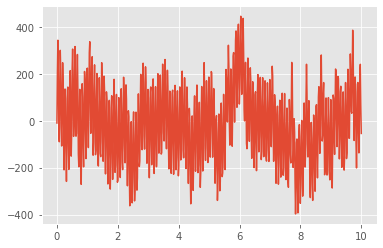

In [27]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_264.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [28]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [29]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
#dm.apply_dvariance_filter(30)
#dm.mean_pooling_1d(size = 15, stride = 13, padding = 0)
print(dm)

X_train: shape of(1804, 50, 640)
X_test: shape of(1830, 50, 640)
Y_train: shape of(1804, 1)
Y_test: shape of(1830, 1)
A_train: shape of(50, 50)
A_test: shape of(50, 50)
P_avg_train: shape of(50, 50)
P_avg_test: shape of(50, 50)
X_train: shape of(1804, 50, 640)
X_test: shape of(1830, 50, 640)
Y_train: shape of(1804, 1)
Y_test: shape of(1830, 1)
A_train: shape of(50, 50)
A_test: shape of(50, 50)
P_avg_train: shape of(50, 50)
P_avg_test: shape of(50, 50)


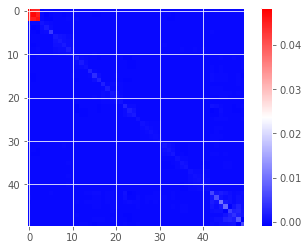

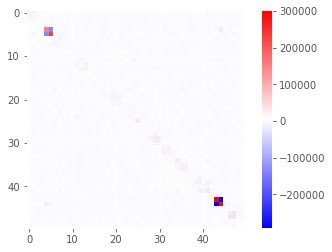

In [30]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

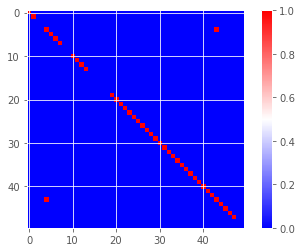

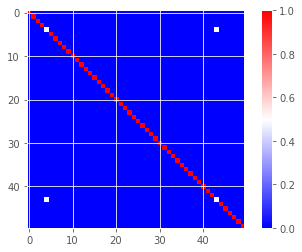

In [31]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

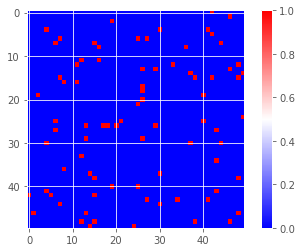

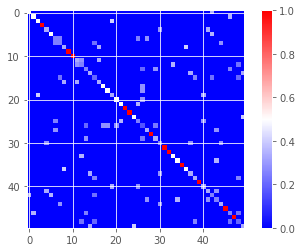

In [32]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

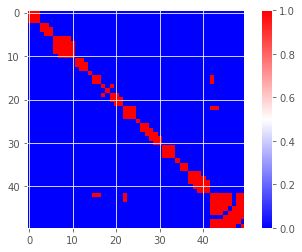

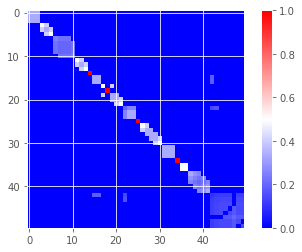

In [37]:
n = 2.5*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw =  dm.A_train#A3#A2 #dm.A_train

In [38]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 512,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 64], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

In [39]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, Araw)

  0%|          | 0/4 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu


 25%|██▌       | 1/4 [00:02<00:06,  2.03s/it]

 50%|█████     | 2/4 [00:04<00:04,  2.07s/it]

 75%|███████▌  | 3/4 [00:06<00:02,  2.10s/it]

100%|██████████| 4/4 [00:07<00:00,  1.89s/it]

Epoch: 1   Batch: 4 of size 512   Train loss: 694.8338623046875   Valid loss: 686.1686401367188
----------Training Ends-----------
----------Training GDE-----------
device set to cpu



  7%|▋         | 1/15 [00:02<00:40,  2.90s/it]

 13%|█▎        | 2/15 [00:05<00:38,  2.94s/it]

 20%|██        | 3/15 [00:08<00:35,  2.96s/it]

 27%|██▋       | 4/15 [00:11<00:32,  2.97s/it]

 33%|███▎      | 5/15 [00:14<00:29,  2.97s/it]

 40%|████      | 6/15 [00:17<00:26,  2.99s/it]

 47%|████▋     | 7/15 [00:20<00:23,  2.97s/it]

 53%|█████▎    | 8/15 [00:23<00:20,  2.97s/it]

 60%|██████    | 9/15 [00:26<00:17,  2.94s/it]

 67%|██████▋   | 10/15 [00:29<00:14,  2.95s/it]

 73%|███████▎  | 11/15 [00:32<00:11,  2.95s/it]

 80%|████████  | 12/15 [00:35<00:08,  2.94s/it]

 87%|████████▋ | 13/15 [00:38<00:05,  2.94s/it]

 93%|█████████▎| 14/15 [00:41<00:02,  2.92s/it]

100%|██████████| 15/15 [00:41<00:00,  2.78s/it]

Epoch: 1   Batch: 15 of size 128   Train loss: 661.9655151367188   Valid loss: 660.7202758789062
----------Training Ends-----------


----------Training MLP-----------
0.441 ----------saved-----------
0.518 ----------saved-----------
0.564 ----------saved-----------


C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.568 ----------saved-----------
0.581 ----------saved-----------
0.207 ----------saved-----------
0.262 ----------saved-----------
0.378 ----------saved-----------
0.43 ----------saved-----------
0.461 ----------saved-----------
0.471 ----------saved-----------
0.484 ----------saved-----------
0.505 ----------saved-----------
0.525 ----------saved-----------
0.53 ----------saved-----------
0.535 ----------saved-----------
0.536 ----------saved-----------
0.541 ----------saved-----------
----------Training Ends-----------


GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.3852 F1 accuracy 0.515 Precision accuracy 0.539 Recall accuracy 0.493 AUC accuracy: 0.718
device set to cuda
threshold: 0.1  validation loss: 0.3852 F1 accuracy 0.581 Precision accuracy 0.805 Recall accuracy 0.455 AUC accuracy: 0.718
device set to cuda
threshold: 0.15  validation loss: 0.3852 F1 accuracy 0.572 Precision accuracy 0.916 Recall accuracy 0.416 AUC accuracy: 0.718
device set to cuda
threshold: 0.2  validation loss: 0.3852 F1 accuracy 0.522 Precision accuracy 0.927 Recall accuracy 0.364 AUC accuracy: 0.718
device set to cuda
threshold: 0.25  validation loss: 0.3852 F1 accuracy 0.488 Precision accuracy 0.932 Recall accuracy 0.33 AUC accuracy: 0.718
device set to cuda
threshold: 0.3  validation loss: 0.3852 F1 accuracy 0.451 Precision accuracy 0.939 Recall accuracy 0.297 AUC accuracy: 0.718
device set to cuda
threshold: 0.35  validation loss: 0.3852 F1 accuracy 0.424 Precision accuracy 0.95 Recall accuracy 0.

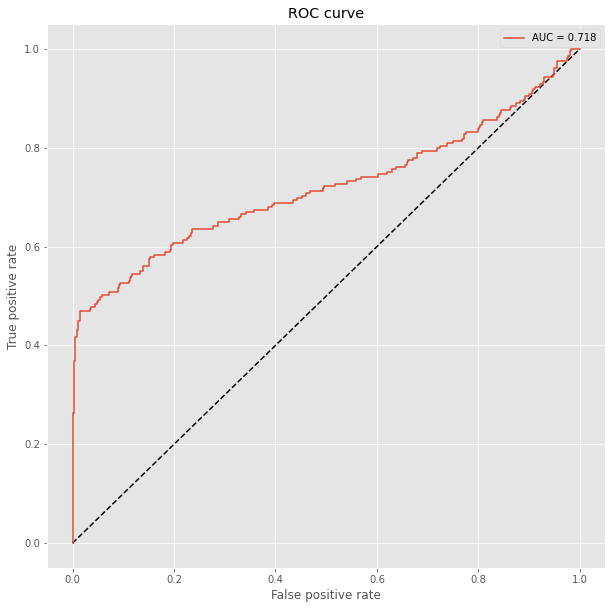

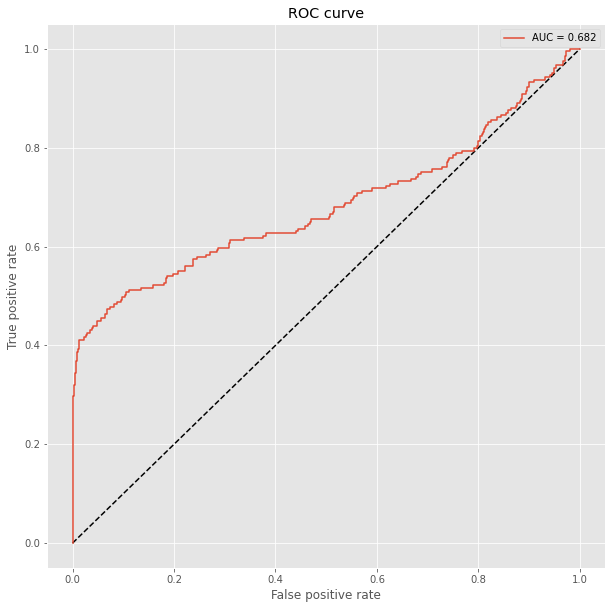

In [40]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')